# Round Trip Tear Sheet Example

When evaluating the performance of an investing strategy, it is helpful to quantify the frequency, duration, and profitability of its independent bets, or "round trip" trades. A round trip trade is started when a new long or short position is opened and then later completely or partially closed out.

The intent of the round trip tearsheet is to help differentiate strategies that profited off a few lucky trades from strategies that profited repeatedly from genuine alpha. Breaking down round trip profitability by traded name and sector can also help inform universe selection and identify exposure risks. For example, even if your equity curve looks robust, if only two securities in your universe of fifteen names contributed to overall profitability, you may have reason to question the logic of your strategy.

To identify round trips, pyfolio reconstructs the complete portfolio based on the transactions that you pass in. When you make a trade, pyfolio checks if shares are already present in your portfolio purchased at a certain price. If there are, we compute the PnL, returns and duration of that round trip trade. In calculating round trips, pyfolio will also append position closing transactions at the last timestamp in the positions data. This closing transaction will cause the PnL from any open positions to realized as completed round trips.

In [1]:
#import sys
#sys.modules.pop('pyfolio', None)
import pyfolio as pf
print(pf.__version__)
%matplotlib inline
import gzip
#import os
import pandas as pd

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/opt/miniconda3/envs/analysis/lib/python3.11/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


0.9.3+186.ga0c906e.dirty


In [6]:
transactions = pd.read_csv(gzip.open('/Users/linda/myprojects/github/pyfolio/pyfolio/tests/test_data/test_txn.csv.gz'),#c:\\myprojects\\github\\pyfolio\\pyfolio\\tests\\test_data\\
                    index_col=0, parse_dates=True)
positions = pd.read_csv(gzip.open('/Users/linda/myprojects/github/pyfolio/pyfolio/tests/test_data/test_pos.csv.gz'),#
                    index_col=0, parse_dates=True)
returns = pd.read_csv(gzip.open('/Users/linda/myprojects/github/pyfolio/pyfolio/tests/test_data/test_returns.csv.gz'),
                      index_col=0, parse_dates=True, header=None)[1]
returns.columns = ['returns']
returns = returns[returns.index >= positions.index[0]]
transactions_sid_0 = transactions[transactions['sid'] == 0]
#print('shape of returns: ', returns.shape)
#print('shape of positions: ', positions.shape)
#print('shape of transactions: ', transactions.shape)
print('returns: ', returns.head())
print('positions: ', positions.head())
print('transactions: ', transactions.head(20))
#print('returns: ', returns.tail())
#print('positions: ', positions.tail())
#print('transactions: ', transactions.tail())

returns:  0
2004-01-09 00:00:00+00:00   -4.282629e-13
2004-01-12 00:00:00+00:00    8.606115e-03
2004-01-13 00:00:00+00:00   -1.899073e-02
2004-01-14 00:00:00+00:00    8.175663e-03
2004-01-15 00:00:00+00:00   -3.031564e-03
Name: 1, dtype: float64
positions:                                  AMD         CERN          COST         DELL  \
index                                                                         
2004-01-09 00:00:00+00:00   6961.92  21017.07875   7282.266152  21264.55188   
2004-01-12 00:00:00+00:00  18198.58  18071.25000  17675.836401  10804.31924   
2004-01-13 00:00:00+00:00  12060.86  11942.24625  12838.477446  16078.90380   
2004-01-14 00:00:00+00:00  13102.40  15534.28125  14447.422640  15414.45080   
2004-01-15 00:00:00+00:00  15518.40  14547.05000  14164.039680  14407.48813   

                                    GPS          INTC           MMM  \
index                                                                 
2004-01-09 00:00:00+00:00   7091.080020  21259

In [3]:
# Optional: Sector mappings may be passed in as a dict or pd.Series. If a mapping is
# provided, PnL from symbols with mappings will be summed to display profitability by sector.
sect_map = {'COST': 'Consumer Goods', 'INTC':'Technology', 'CERN':'Healthcare', 'GPS':'Technology',
            'MMM': 'Construction', 'DELL': 'Technology', 'AMD':'Technology'}

The easiest way to run the analysis is to call `pyfolio.create_round_trip_tear_sheet()`. Passing in a sector map is optional. You can also pass `round_trips=True` to `pyfolio.create_full_tear_sheet()` to have this be created along all the other analyses.

总览指标,所有交易,做空交易,做多交易
总交易数,5819.00,1155.00,4664.00
盈利百分比,0.50,0.52,0.49
盈利交易数,2887.00,595.00,2292.00
亏损交易数,2914.00,553.00,2361.00
平局交易数,18.00,7.00,11.00


盈亏指标,所有交易,做空交易,做多交易
总净利润,67003.94,3531.32,63472.61
总盈利,448674.42,20579.67,428094.75
总亏损,-381670.48,-17048.35,-364622.13
利润因子,1.18,1.21,1.17
所有交易平均净利润,11.51,3.06,13.61
盈利交易平均净利润,155.41,34.59,186.78
亏损交易平均净利润,-130.98,-30.83,-154.44
盈亏比率,1.19,1.12,1.21
最大盈利,9500.14,1623.24,9500.14
最大亏损,-22902.83,-661.29,-22902.83


持有期指标,所有交易,做空交易,做多交易
平均持续时间-天,13,2,15
中位数持续时间-天,8,2,12
最长持续时间-天,84,13,84
最短持续时间-天,1,1,1


收益指标,所有交易,做空交易,做多交易
所有交易的平均收益,0.01%,0.00%,0.01%
盈利交易的平均收益,0.13%,0.03%,0.15%
亏损交易的平均收益,-0.11%,-0.03%,-0.13%
所有交易的中位数收益,-0.00%,0.00%,-0.00%
盈利交易的中位数收益,0.02%,0.01%,0.03%
亏损交易的中位数收益,-0.01%,-0.00%,-0.02%
最大盈利交易,6.78%,1.37%,6.78%
最大亏损交易,-17.23%,-0.72%,-17.23%


交易品种指标,AMD,CERN,COST,DELL,GPS,INTC,MMM
所有交易的平均收益,-0.00%,0.02%,0.02%,-0.03%,0.00%,0.02%,0.01%
盈利交易的平均收益,0.20%,0.15%,0.10%,0.11%,0.10%,0.11%,0.10%
亏损交易的平均收益,-0.19%,-0.13%,-0.07%,-0.15%,-0.09%,-0.06%,-0.09%
所有交易的中位数收益,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%
盈利交易的中位数收益,0.03%,0.02%,0.02%,0.02%,0.02%,0.01%,0.02%
亏损交易的中位数收益,-0.02%,-0.01%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%
最大盈利交易,6.78%,6.14%,3.96%,2.78%,1.80%,2.40%,2.45%
最大亏损交易,-17.23%,-3.92%,-2.32%,-6.39%,-6.86%,-4.45%,-1.79%


每个交易品种的净利润占比,
symbol,
COST,39.07%
INTC,37.19%
CERN,31.54%
MMM,21.58%
GPS,4.91%
AMD,-6.24%
DELL,-28.03%


每个交易品种的净利润占比,
symbol,
Consumer Goods,39.07%
Healthcare,31.54%
Construction,21.58%
Technology,7.82%


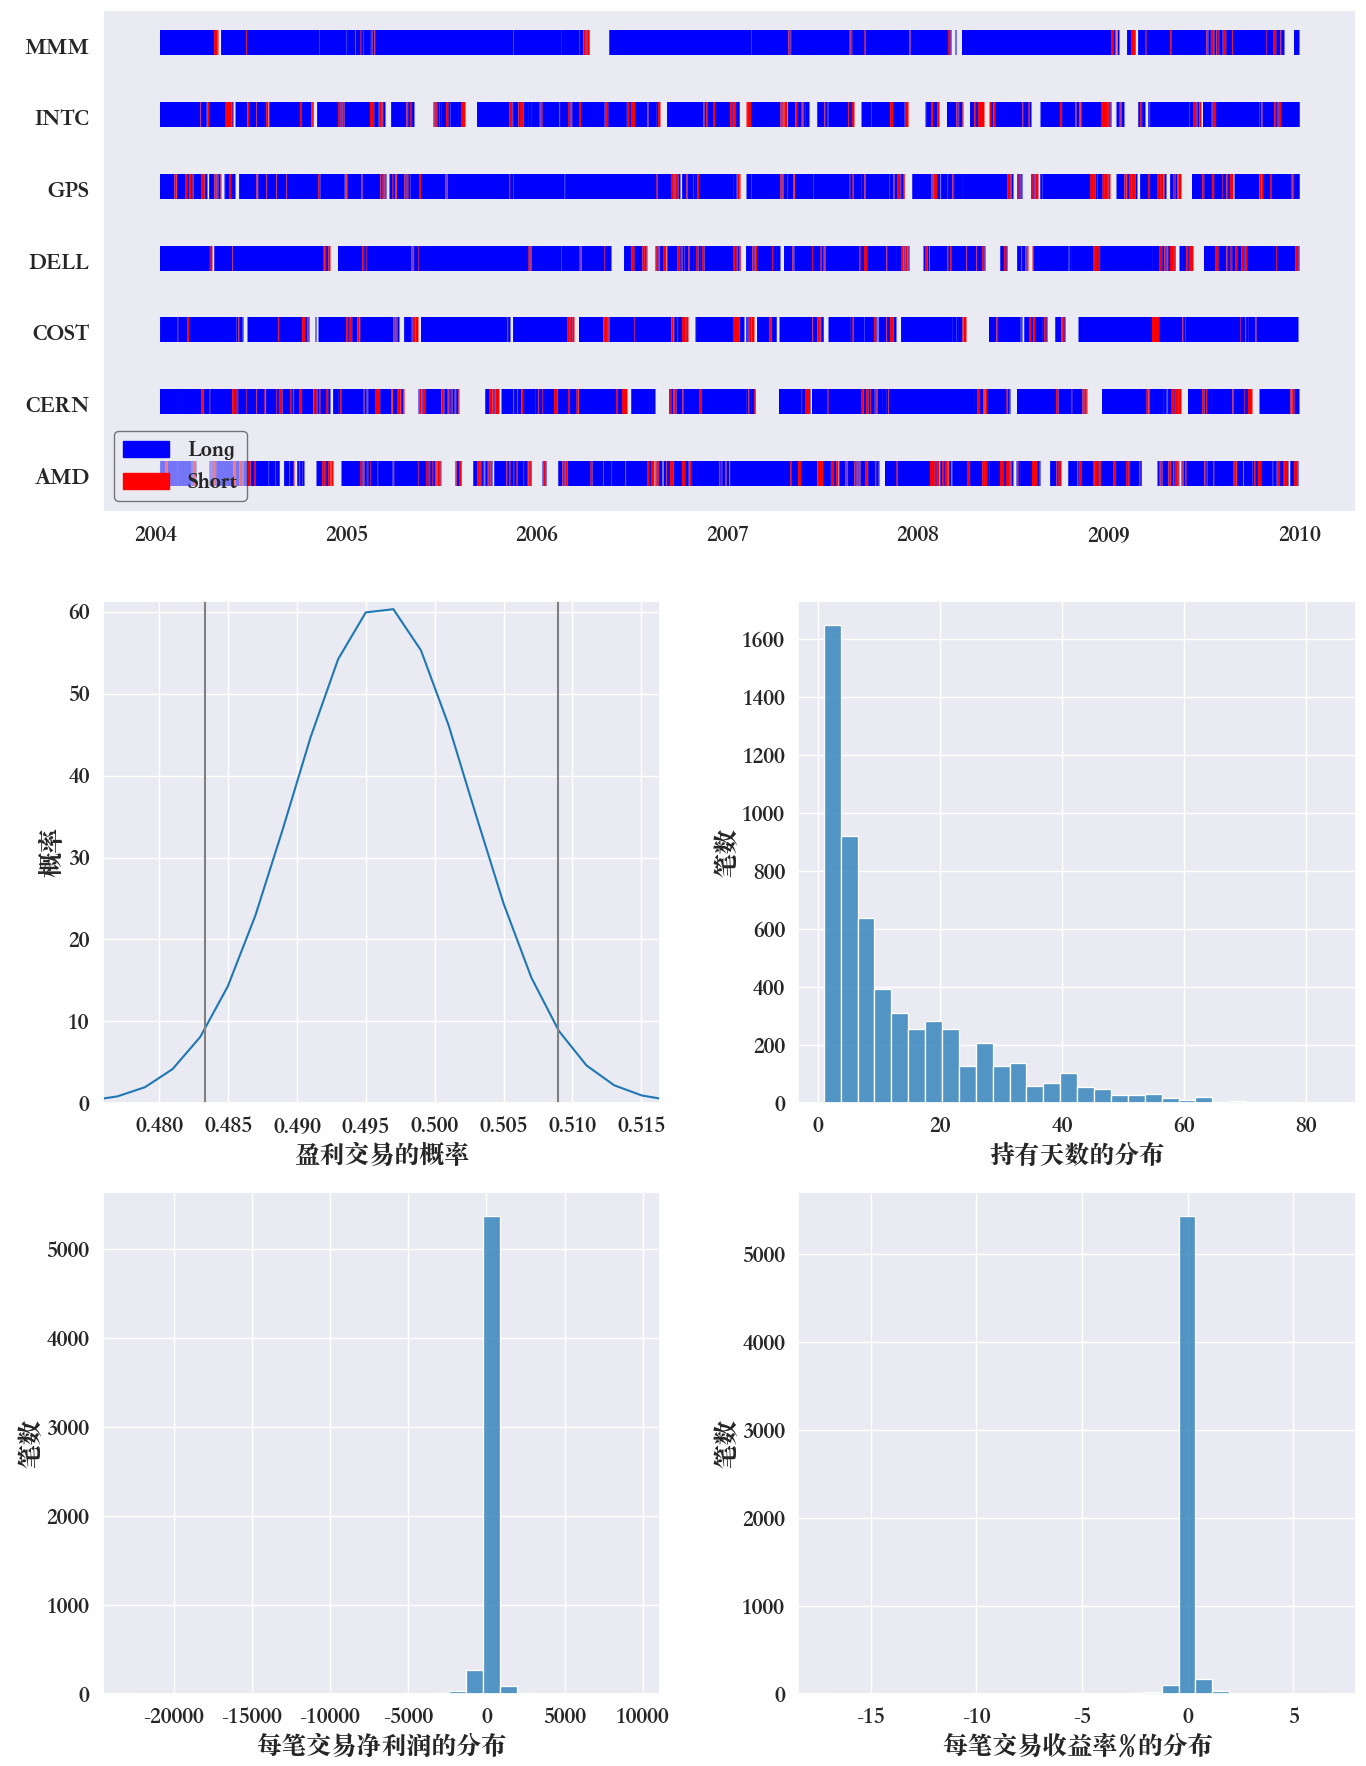

In [4]:
pf.create_round_trip_tear_sheet(returns, positions, transactions, sector_mappings=sect_map)

Under the hood, several functions are being called. `extract_round_trips()` does the portfolio reconstruction and creates the round-trip trades.

In [5]:
rts = pf.round_trips.extract_round_trips(transactions, 
                                         portfolio_value=positions.sum(axis='columns') / (returns + 1))

In [6]:
rts.head()

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration,returns
0,-126.000000,2004-01-09 00:00:00+00:00,2004-01-13 00:00:00+00:00,True,-0.022523,AMD,4 days,-0.001249
1,50.020000,2004-01-09 00:00:00+00:00,2004-01-16 00:00:00+00:00,True,0.078507,AMD,7 days,0.000503
2,1540.099065,2004-01-09 00:00:00+00:00,2004-01-20 00:00:00+00:00,True,0.104696,AMD,11 days,0.015257
3,287.119806,2004-01-20 00:00:00+00:00,2004-01-21 00:00:00+00:00,False,0.085155,AMD,1 days,0.002861
4,103.349947,2004-01-20 00:00:00+00:00,2004-01-22 00:00:00+00:00,False,0.112198,AMD,2 days,0.001032


In [7]:
pf.round_trips.print_round_trip_stats(rts)

总览指标,所有交易,做空交易,做多交易
总交易数,5819.00,1155.00,4664.00
盈利百分比,0.50,0.52,0.49
盈利交易数,2887.00,595.00,2292.00
亏损交易数,2914.00,553.00,2361.00
平局交易数,18.00,7.00,11.00


盈亏指标,所有交易,做空交易,做多交易
总净利润,67003.94,3531.32,63472.61
总盈利,448674.42,20579.67,428094.75
总亏损,-381670.48,-17048.35,-364622.13
利润因子,1.18,1.21,1.17
所有交易平均净利润,11.51,3.06,13.61
盈利交易平均净利润,155.41,34.59,186.78
亏损交易平均净利润,-130.98,-30.83,-154.44
盈亏比率,1.19,1.12,1.21
最大盈利,9500.14,1623.24,9500.14
最大亏损,-22902.83,-661.29,-22902.83


持有期指标,所有交易,做空交易,做多交易
平均持续时间-天,13,2,15
中位数持续时间-天,8,2,12
最长持续时间-天,84,13,84
最短持续时间-天,1,1,1


收益指标,所有交易,做空交易,做多交易
所有交易的平均收益,0.01%,0.00%,0.01%
盈利交易的平均收益,0.13%,0.03%,0.15%
亏损交易的平均收益,-0.11%,-0.03%,-0.13%
所有交易的中位数收益,-0.00%,0.00%,-0.00%
盈利交易的中位数收益,0.02%,0.01%,0.03%
亏损交易的中位数收益,-0.01%,-0.00%,-0.02%
最大盈利交易,6.78%,1.37%,6.78%
最大亏损交易,-17.23%,-0.72%,-17.23%


交易品种指标,AMD,CERN,COST,DELL,GPS,INTC,MMM
所有交易的平均收益,-0.00%,0.02%,0.02%,-0.03%,0.00%,0.02%,0.01%
盈利交易的平均收益,0.20%,0.15%,0.10%,0.11%,0.10%,0.11%,0.10%
亏损交易的平均收益,-0.19%,-0.13%,-0.07%,-0.15%,-0.09%,-0.06%,-0.09%
所有交易的中位数收益,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,0.00%
盈利交易的中位数收益,0.03%,0.02%,0.02%,0.02%,0.02%,0.01%,0.02%
亏损交易的中位数收益,-0.02%,-0.01%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%
最大盈利交易,6.78%,6.14%,3.96%,2.78%,1.80%,2.40%,2.45%
最大亏损交易,-17.23%,-3.92%,-2.32%,-6.39%,-6.86%,-4.45%,-1.79%
